In [123]:
import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import log_loss

import xlearn as xl

## Reading data

In [94]:
df = pd.read_csv('../../data/data.csv')

## Functions for analysing and feature transforming

In [95]:
def analysis(df: pd.DataFrame) -> pd.DataFrame:
    """
    This function for dataset given in task makes some basic 
    data processing including dropping unnecessary columns,
    dropping outliers, searching for missing values and gives
    some plots (frequency of click, conversion in click by hours, etc).
    """
    # парсим дату в строку вида yyyy-MM-dd
    df['date_time_str'] = df['date_time'].apply(lambda x: x[:10])
    # отбрасываем ненужные колонки
    df = df.drop(columns=[
        'banner_id0', 
        'banner_id1',
        'rate0', 
        'rate1', 
        'g0', 
        'g1',
        'coeff_sum0', 
        'coeff_sum1', 
        'impressions'  # странная фича, у которой всего одно уникальное значение, удалим
    ]).sort_values(by=['date_time']).reset_index(drop=True)  # сортируем по дате
    
    # как обстоит ситуация с хешами пользователей
    val_cnts = df['oaid_hash'].value_counts()
    print(val_cnts)
    print(f'Всего {val_cnts.shape[0]} уникальных хешей пользователей, из которых:')
    print(f'{val_cnts[val_cnts == 1].shape[0]/val_cnts.shape[0]:.2f} доля хешей, которые встречаются в датасете всего один раз')
    print(f'{val_cnts[val_cnts <= 10].shape[0]/val_cnts.shape[0]:.2f} доля хешей, которые встречаются в датасете не больше десяти раз')
    print(f'{val_cnts[val_cnts > 10].shape[0]/val_cnts.shape[0]:.2f} доля хешей, которые встречаются в датасете больше десяти раз')
    print('\n\n')
    
    # подсчет суммарного количества наблюдений по дате до удаления выбросов
    print('Before deleting outliers:\n')

    tmp = df[['date_time_str', 'clicks']].groupby('date_time_str').count().reset_index()
    tmp.columns = ['date_time', 'number_of_rows']
    print(tmp)

    plt.figure(figsize=(10, 7))
    plt.plot(tmp['date_time'], tmp['number_of_rows'])
    plt.title('Distibution of rows by dates before deleting outliers', size=20)
    plt.xlabel('Date', size=14)
    plt.ylabel('Number of rows, millions', size=14)
    plt.show()
    
    # оказалось что наблюдение с такой датой - выброс
    df = df[df['date_time_str'] != '2021-09-01'].reset_index(drop=True)
    
    # подсчет суммарного количества наблюдений по дате после удаления выбросов
    print('After deleting outliers:\n')

    tmp = df[['date_time_str', 'clicks']].groupby('date_time_str').count().reset_index()
    tmp.columns = ['date_time', 'number_of_rows']
    print(tmp)

    plt.figure(figsize=(10, 7))
    plt.plot(tmp['date_time'], tmp['number_of_rows'])
    plt.title('Distibution of rows by dates after deleting outliers', size=20)
    plt.xlabel('Date', size=14)
    plt.ylabel('Number of rows, millions', size=14)
    plt.show()
    
    del tmp
    
    # подсчет пропущенных значений
    print('Missing values by each feature:')
    print(df.isnull().sum())
    
    # подсчет частоты клика
    print('\nFrequency of not click and click:')
    print(df['clicks'].value_counts(normalize=True))
    plt.figure(figsize=(10, 7))
    df['clicks'].value_counts(normalize=True).plot(kind = 'barh')
    plt.title('Barplot of frequency of click/not click', size=20)
    plt.xlabel('Frequency of click/not click', size=14)
    plt.ylabel('Click/not click', size=14)
    plt.show()
    
    # подсчет конверсии в клик по часам
    tmp = df[['date_time', 'clicks']]
    tmp['hour'] = tmp['date_time'].apply(lambda x: x[11:13])
    tmp = tmp[['hour', 'clicks']].groupby('hour').mean().reset_index()
    plt.figure(figsize=(10, 7))
    plt.plot(tmp['hour'], tmp['clicks'])
    plt.xlabel('Hour of conversion', size=14)
    plt.ylabel('Conversion', size=14)
    plt.title('Conversion in click by hours', size=20)
    plt.show()
    
    del tmp
    
    return df

In [96]:
def feature_transforming(df: pd.DataFrame) -> pd.DataFrame:
    """
    This function creates new columns in dataframe related
    somehow to date time of observation: it gets
    month number, week number, day week number, 
    day week status (working day/weekend), hour number, 
    minute number and second number.
    """
    # трансформируем строку в пандасовскую дату
    df['date_time'] = pd.to_datetime(df['date_time'])
    # вытаскиваем различные полезные фичи из полной даты каждого наблюдения:
    # получаем номер месяца наблюдения
    df['month_num'] = df['date_time'].apply(lambda x: x.month)
    # получаем номер недели наблюдения
    df['week_num'] = df['date_time'].apply(lambda x: x.week)
    # получаем номер дня недели наблюдения
    df['day_week_num'] = df['date_time'].apply(lambda x: x.dayofweek)
    # получаем информацию о дне наблюдения - выходной или рабочий день
    df['day_week_status'] = df['day_week_num'].apply(
        lambda x: 0 if 1 <= x <= 5 else 1
    )
    # получаем номер часа наблюдения
    df['hour_num'] = df['date_time'].apply(lambda x: x.hour)
    # получаем номер минуты наблюдения
    df['minute_num'] = df['date_time'].apply(lambda x: x.minute)
    # получаем номер секунды наблюдения
    df['second_num'] = df['date_time'].apply(lambda x: x.second)
    # отбрасываем колонку с пандасовской датой
    df.drop(columns=['date_time'], inplace=True)
    return df

## Basic data preprocessing and data analysis

На данном этапе:
- Отбрасываем лишние (по условию первого ДЗ) признаки
- Удаляем выбросы (в частности, одно наблюдения - датой 2021-09-01)
- Смотрим, есть ли пропущенные значения
- Смотрим на частоту клика
- Смотрим наконверсию в клик по часам

Feature transforming - вытягиваем различные признаки временных рядов:
- месяц наблюдения
- неделя наблюдения
- день наблюдения
- выходной/рабочий день
- час наблюдения
- минута наблюдения
- секунда наблюдения

308174966294367527     5243
2890718152668627077    2511
2521895603443866206    2289
8212556321845734673    1974
3375698397737628939    1959
                       ... 
8145984302456198885       1
4322636670368844065       1
2944515553538779465       1
2998076616214418300       1
5569517219693927594       1
Name: oaid_hash, Length: 6510316, dtype: int64
Всего 6510316 уникальных хешей пользователей, из которых:
0.64 доля хешей, которые встречаются в датасете всего один раз
0.97 доля хешей, которые встречаются в датасете не больше десяти раз
0.03 доля хешей, которые встречаются в датасете больше десяти раз



Before deleting outliers:

    date_time  number_of_rows
0  2021-09-01               1
1  2021-09-26         3102610
2  2021-09-27         2367303
3  2021-09-28         2307355
4  2021-09-29         2420588
5  2021-09-30         1851189
6  2021-10-01         1643448
7  2021-10-02         2128978


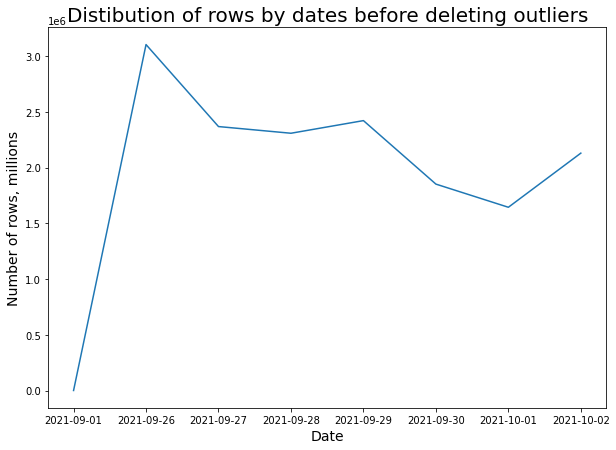

After deleting outliers:

    date_time  number_of_rows
0  2021-09-26         3102610
1  2021-09-27         2367303
2  2021-09-28         2307355
3  2021-09-29         2420588
4  2021-09-30         1851189
5  2021-10-01         1643448
6  2021-10-02         2128978


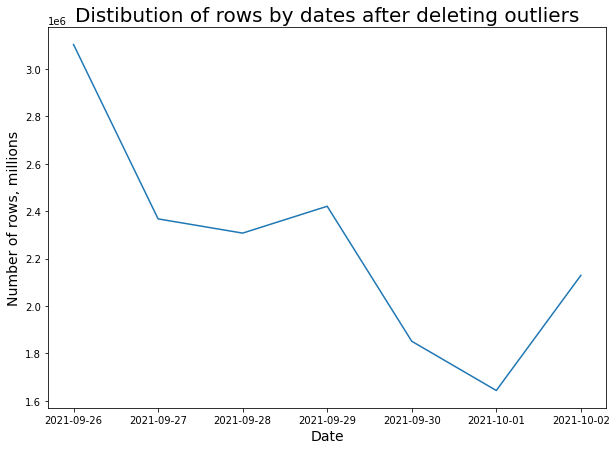

Missing values by each feature:
date_time          0
zone_id            0
banner_id          0
oaid_hash          0
campaign_clicks    0
os_id              0
country_id         0
clicks             0
date_time_str      0
dtype: int64

Frequency of not click and click:
0    0.973312
1    0.026688
Name: clicks, dtype: float64


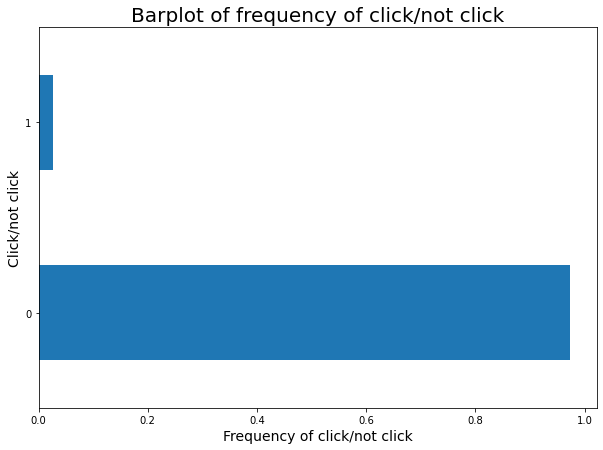

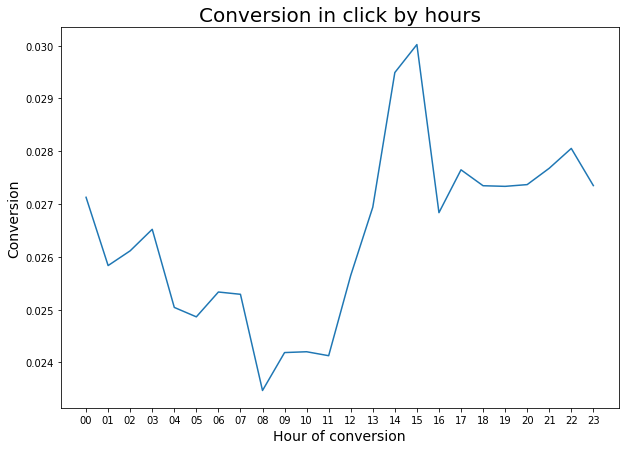

In [97]:
df = analysis(df)

Аналитические выводы:
- Одно наблюдение было выбросом, которое имело дату сильно несопоставимую с общей массой
- Пропущенных значений в датасете нет
- Исходя из графика конверсии в клик по часам, хочется выделить различные фичи, связанные с временем события - месяц, день, час, минута, секунда, потому что все это в совокупности важно
- НЕкликов сильно больше чем кликов - почти в 49 раз, поэтому хочется расти в увеличение именно полноты, а не точность
- Много хешей, которые встречаются в датасете один раз (64%), много хешей, которые встречаются в датасете не больше 10 раз (97%); что делать с ними - большой вопрос, можно, например, объединить в один все хеши, которые встречаются меньше n раз, а можно оставить все как есть и хранить хеш каждого юзера (мы так и сделаем), чтобы в дальнейшем иметь информацию про него

In [61]:
df = feature_transforming(df)

Выделяем временные признаки и разделяем датасет на трейн, валидацию и тест. Трейн - все что раньше 1 октября, валидация - 1 октября, тест - 2 октября. Также создадим датафрейм с объединением трейна и валидации.

In [62]:
train_df = df[df['date_time_str'] < '2021-10-01']
validation_df = df[df['date_time_str'] == '2021-10-01']
test_df = df[df['date_time_str'] == '2021-10-02']
train_and_validation_df = df[df['date_time_str'] < '2021-10-02']

Функция для создания .txt файла в необходимом формате для библиотеки xlearn.

In [129]:
def upload_dataframe_into_txt_file(df, path):
    with open(path, "w") as f:
        lines = []
        for i in tqdm(range(df.shape[0])):
            row = df.iloc[i, :]
            y = row['clicks'].astype(str)
            field_user = '1:1:' + row['oaid_hash'].astype(str) + ',1:2:' + row['os_id'].astype(str) + ',1:3:' + row['country_id'].astype(str)
            field_context = '2:1:' + row['zone_id'].astype(str) + ',2:2:' + row['month_num'].astype(str) + ',2:3:' + row['week_num'].astype(str) + ',2:4:' + row['day_week_num'].astype(str) + ',2:5:' + row['day_week_status'].astype(str) + ',2:6:' + row['hour_num'].astype(str) + ',2:7:' + row['minute_num'].astype(str) + ',2:8:' + row['second_num'].astype(str)
            field_banner = '3:1:' + row['banner_id'].astype(str) + ',3:2:' + row['campaign_clicks'].astype(str)
            row_str = y.astype(str) + ',' + field_user + ',' + field_context + ',' + field_banner
            lines.append(row_str)
        f.write("\n".join(lines))

In [130]:
upload_dataframe_into_txt_file(train_df, 'train.txt')
upload_dataframe_into_txt_file(validation_df, 'validation.txt')
upload_dataframe_into_txt_file(test_df, 'test.txt')
upload_dataframe_into_txt_file(train_and_validation_df, 'train_and_validation.txt')

100%|███████████████████████████████| 2128978/2128978 [06:42<00:00, 5292.46it/s]


На запись трейна, валидации и теста в .txt понадобилось около, поэтому нормально валидироваться по времени, используя таймсериес сплит не представляется возможным - пришлось бы записывать очень много фолдов в .txt, это было бы долго. 

Поэтому, будем валидироваться по упрощенной схеме: разобьем датасет на тест (то что раньше 1 октября), валидацию (1 октября) и тест (2 октября) - заметим что все соответствует принципу валидации, тест позже трейна и валидации, а валидация позже трейна и раньше теста, и будем в кроссвалидации перебирать параметры на трейне, а оценивать логлосс и сравнивать между собой на валидации, так подберем лучшие параметры, а затем получим предикшен для теста и посчитаем на нем логлосс.

Функция проверки каждой комбинации параметров на сетке, обучаемся на трейне и записываем в словарь значения логлосса на валидационном дне, чтобы можно было сравнивать качества моделей между собой.

Перебирать будем скорость обучения градиентного спуска `lr` и параметр снижения размерности `k`. Хотелось бы, конечно, еще перебирать и параметр регуляризации `lambda`, но это было бы очень долго, поэтому пришлось остановиться на лернинг рейте и k :(

Также, мы ограничены количеством перебираемых параметров - хотелось бы перебирать сильно больше различных `k` и `lr` - возможно, если бы перебиралось больше параметров, итоговый скор был бы сильно лучше.

In [54]:
def cv(lrs, ks, train_path, validation_path):
    d = {lr: {k: None for k in ks} for lr in lrs}
    for lr in tqdm(lrs):
        for k in tqdm(ks):
            model = xl.create_ffm()
            model.setTrain(train_path)
            param = {'task':'binary', 'lr':lr, 'lambda': 0.001, 'k': k, 'metric': 'recall'}
            model.fit(param, model_path='./model.out')
            model.setSigmoid()
            
            model.setTest(validation_path)
            model.predict("./model.out", "./output.txt")
            d[lr][k] = log_loss(validation_df['clicks'], pd.read_csv('output.txt', header=None))
    return d

In [63]:
lrs = [0.01, 0.05, 0.1]
ks = [2, 4, 6]
results = cv(lrs, ks, 'train.txt', 'validation.txt')

  0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[ WARNING    ] Validation file not found, xLearn has already disable early-stopping.
[ WARNING    ] Validation file not found, xLearn has already disable (-x recall) option.
[------------] xLearn uses 16 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (train.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 9
[------------] Number of Field: 4
[------------] Time cost for reading problem: 18.59 (sec)
[ ACTION     ] Initialize


 33%|███▎      | 1/3 [06:08<12:17, 368.87s/it]

----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[ WARNING    ] Validation file not found, xLearn has already disable early-stopping.
[ WARNING    ] Validation file not found, xLearn has already disable (-x recall) option.
[------------] xLearn uses 16 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (train.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 9
[------------] Number of Field: 4
[------------] Time cost for reading problem: 21.21 (sec)
[ ACTION     ] Initialize


 67%|██████▋   | 2/3 [12:46<06:25, 385.94s/it]

----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[ WARNING    ] Validation file not found, xLearn has already disable early-stopping.
[ WARNING    ] Validation file not found, xLearn has already disable (-x recall) option.
[------------] xLearn uses 16 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (train.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 9
[------------] Number of Field: 4
[------------] Time cost for reading problem: 18.59 (sec)
[ ACTION     ] Initialize


  0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[ WARNING    ] Validation file not found, xLearn has already disable early-stopping.
[ WARNING    ] Validation file not found, xLearn has already disable (-x recall) option.
[------------] xLearn uses 16 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (train.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 9
[------------] Number of Field: 4
[------------] Time cost for reading problem: 20.06 (sec)
[ ACTION     ] Initialize


 33%|███▎      | 1/3 [06:20<12:41, 380.79s/it]

----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[ WARNING    ] Validation file not found, xLearn has already disable early-stopping.
[ WARNING    ] Validation file not found, xLearn has already disable (-x recall) option.
[------------] xLearn uses 16 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (train.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 9
[------------] Number of Field: 4
[------------] Time cost for reading problem: 17.40 (sec)
[ ACTION     ] Initialize


 67%|██████▋   | 2/3 [12:44<06:22, 382.44s/it]

----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[ WARNING    ] Validation file not found, xLearn has already disable early-stopping.
[ WARNING    ] Validation file not found, xLearn has already disable (-x recall) option.
[------------] xLearn uses 16 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (train.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 9
[------------] Number of Field: 4
[------------] Time cost for reading problem: 19.06 (sec)
[ ACTION     ] Initialize


  0%|          | 0/3 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[ WARNING    ] Validation file not found, xLearn has already disable early-stopping.
[ WARNING    ] Validation file not found, xLearn has already disable (-x recall) option.
[------------] xLearn uses 16 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (train.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 9
[------------] Number of Field: 4
[------------] Time cost for reading problem: 20.50 (sec)
[ ACTION     ] Initialize


 33%|███▎      | 1/3 [08:15<16:31, 495.84s/it]

----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[ WARNING    ] Validation file not found, xLearn has already disable early-stopping.
[ WARNING    ] Validation file not found, xLearn has already disable (-x recall) option.
[------------] xLearn uses 16 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (train.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 9
[------------] Number of Field: 4
[------------] Time cost for reading problem: 20.72 (sec)
[ ACTION     ] Initialize


 67%|██████▋   | 2/3 [16:28<08:14, 494.14s/it]

----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[ WARNING    ] Validation file not found, xLearn has already disable early-stopping.
[ WARNING    ] Validation file not found, xLearn has already disable (-x recall) option.
[------------] xLearn uses 16 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (train.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 9
[------------] Number of Field: 4
[------------] Time cost for reading problem: 19.84 (sec)
[ ACTION     ] Initialize


100%|██████████| 3/3 [1:26:59<00:00, 1739.71s/it]


In [100]:
tmp = pd.DataFrame(results)
tmp

,0.01,0.05,0.10
2,0.180145,0.178604,0.179436
4,0.180140,0.178786,0.179757
6,0.180022,0.179689,0.179262


Наименьший логлосс при `k` равном 2 и `lr` равном 0.05. Обучим с этими параметрами модель на объединении трейна и валидации.

In [124]:
model = xl.create_ffm()
model.setQuiet()
model.setTrain('train_and_validation.txt')
param = {'task':'binary', 'lr':0.05, 'lambda': 0.001, 'k': 2, 'metric': 'recall'}
model.fit(param, model_path='./model.out')

----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[ WARNING    ] Validation file not found, xLearn has already disable early-stopping.
[ WARNING    ] Validation file not found, xLearn has already disable (-x recall) option.
[------------] xLearn uses 16 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (train_and_validation.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 9
[------------] Number of Field: 4
[------------] Time cost for reading problem: 23.74 (sec)
[ ACTION  

In [125]:
model.setSigmoid()       
model.setTest('test.txt')
model.predict("./model.out", "./output.txt")

----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 16 threads for prediction task.
[ ACTION     ] Load model ...
[------------] Load model from ./model.out
[------------] Loss function: cross-entropy
[------------] Score function: ffm
[------------] Number of Feature: 9
[------------] Number of K: 2
[------------] Number of field: 4
[------------] Time cost for loading model: 0.00 (sec)
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (test.txt.bin) found. Skip converting text to binary.
[------------] Time

In [126]:
hw_1_score = 0.13453894092288035
probability_clicks = df[df['date_time_str'] < '2021-10-02']['clicks'].value_counts(normalize=True).iloc[1]
frequency_score = log_loss(
    df[df['date_time_str'] == '2021-10-02']['clicks'],
    [probability_clicks] * df[df['date_time_str'] == '2021-10-02']['clicks'].shape[0]
)
hw_3_score = log_loss(test_df['clicks'], pd.read_csv('output.txt', header=None))
print('Значение log loss на последнем для предсказания:')
print(f'по частоте клика: {frequency_score:.5f}')
print(f'из первого домашнего задания: {hw_1_score:.5f}')
print(f'из текущего домашнего задания: {hw_3_score:.5f}')

Значение log loss на последнем для предсказания:
по частоте клика: 0.15486
из первого домашнего задания: 0.13454
из текущего домашнего задания: 0.15474


## Выводы
Логлосс предикшена FFM оказался хуже логлосса предикшена из первого домашнего задания, более того прдикшен FFM оказался сравним в предикшеном по частоте клика. Почему так произошло и что можно было сделать чтобы резульатат был лучше?
1. Была использована готовая реализация FFM из xlearn и не совсем понятно, как она работает под капотом - может быть ей следовало подать данные, немного в другом формате
2. В исходных данных было много хешей с встречаемостью не более 10 раз, мы все оставили как есть - возможно следовало объединить хеши, которые встречаются меньше n раз в один хеш
3. Реализация xlearnа предполагает загрузку данных из готового .txt файлика что сильно усложнило жизнь: не получилось в полной мере использовать валидацию по времени, потому что пришлось бы крафтить 2 * k (где k - число фолдов) различных .txt файлов с трейном и валидацией, мы обошлись тем, что выделили под трейн все, что раньше 1 октября, под валидацию 1 октября, а под тест 2 октября
4. Количество гиперпараметров FFM сильно больше чем в логистической регрессии, поэтому полноценно перебирать наборы параметров не удалось: из-за долгого обучения пришлось перебирать только 3 лернинг рейта и 3 значения снижения размерности, параметр регуляризации не перебирался; понятно, что хотелось бы перебирать сильно больше параметров